In [26]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')
from itertools import product

from scipy.optimize import minimize_scalar
from scipy.signal import argrelextrema

Let's remind ourselves of the Hamiltonian that we've been working with:

$$H =  A \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + \frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

A and $\delta$ were chosen because of the path of discovery that we took to get here. From now on it will be convenient for us to re-write the Hamiltonian as:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise  $\Delta E$ as the difference in energy of our two state system.

In the last tutorial we saw how the physics of spontaneous emission arose from an indirect coupling between the |+> and |-> states that was mediated by the interaction with a quantised field.

In general, the result of such interactions are far more complicated than the Rabi type oscillations we are becoming familiar with. We got a glimpse of this complexity when we observed that many modes of a quantised field, with slightly different frequencies, interact with the two state system to produce an irregular pattern of probabilities.

The complexity arises because the combined two state system and field have more than two states that can interact with each other strongly if their energies are similar.

We can however still apply ideas we've learnt about two-state systems in some special and interesting situations. This is what we'll explore in this notebook.

To get a feel for this more complicated system we will find the energies/frequencies of the stationary states and see how they depend on the various parameters - just as we did in Fig 3 of Tutorial 2 when we made an avoided crossing plot.

In [78]:
def make_hamilton(max_bosons, delta_E, omega, U):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  delta_E/2*sz                   # two state system energy
    bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
    interaction  = U*(a.dag() + a) * sx            # interaction energy
    
    H = two_state + bosons + interaction
    
    components = {"a":a, "sx":sx, "sz":sz, "two_state":two_state, "bosons": bosons, "interaction":interaction}
    
    return H, components

In [81]:
def make_df_for_energy_scan(label_param, min_param, max_param, num_param, num_levels):
    
    param_values = np.linspace(min_param, max_param, num_param)
    d = {label_param:param_values}
    
    for i in range(num_levels):
        d[f"level_{i}"] = np.zeros(num_param)
        
    df = pd.DataFrame(data=d)
    
    return df

In [50]:
max_bosons = 4
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, 2*(max_bosons+1))

We have 10 levels associated with the 2 states from the two state system (|+>, |->) and 5 bosons states (0,1,2,3,4) making 2*5 = 10 states

In [51]:
df.head()

$\Delta E$  level_0  level_1  level_2  level_3  level_4  level_5  level_6  \
0       -4.00      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1       -3.96      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2       -3.92      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3       -3.88      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4       -3.84      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   level_7  level_8  level_9  
0      0.0      0.0      0.0  
1      0.0      0.0      0.0  
2      0.0      0.0      0.0  
3      0.0      0.0      0.0  
4      0.0      0.0      0.0

We'll now fill these rows with the energies of the different levels (aka the eigenvalues)

In [52]:
for i, row in df.iterrows():
    # Note below the "_" are used because right now we don't want to save the component parts of the Hamiltonian
    H,_ = make_hamiltonian(max_bosons=max_bosons, delta_E=row["$\Delta E$"], omega=1, U=0)
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals   # Fills the columns 1 onwards of row i with the eigenvalues

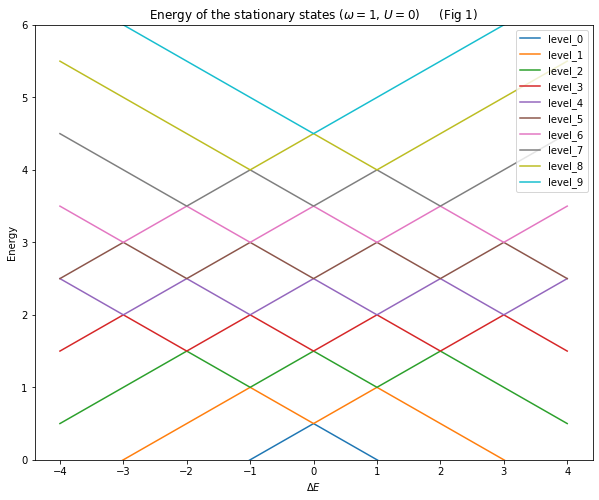

In [53]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[0,6],legend=True, title="Energy of the stationary states ($\omega=1$, $U=0$)     (Fig 1)");
plt.ylabel("Energy");

How do we understand Fig 1?

Start by focusing on where $\Delta E = 0$, i.e. there is no difference between the energies of the |+> and |-> states - this is the very first thing we looked at in Tutorial 1. There are several states/levels that appear to cross each other, they correspond to:
- orange/blue - 0 bosons (|0,±>)
- red/green - 1 boson (|1,±>)
- brown/purple - 2 bosons (|2,±>)
- grey/pink - 3 bosons (|3,±>)
- blue/yellow - 4 bosons (|4,±>)

Let's take the orange (|0,+>) and green (|1,->) lines. As we increase $\Delta E$, The energy of |0,+> goes up  and |1,-> goes down in energy. Eventually, these levels end up with the same energy/frequency even though they have a different number of bosons - this is what allows the |0,+> to interact to |1,-> i.e. it's what makes possible the spontaneous emission we saw in the last tutorial. This particular crossing happens when $\Delta E = \omega = 1$, i.e. the resonance condition we first encountered in Tutorial 2. This is not the only resonance though. We can see there are many non-primary resonances at $\Delta E = \omega, 2\omega, 3\omega $ etc. We can therefore expect that when we switch the coupling on we will see the formation of anti-crossings where the interaction energy splits apart the interactive levels - just as we saw in Tutotial 1. 

In essence, we are now going to try treat these many isolated crossings as if they are acting as independent two state systems.

Let's see how we get on.


In [54]:
max_bosons = 4
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, 2*(max_bosons+1))

for i, row in df.iterrows():
    # Note below the "_" are used because right now we don't want to save the component parts of the Hamiltonian
    H,_ = make_hamiltonian(max_bosons=max_bosons, delta_E=row["$\Delta E$"], omega=1, U=0.2)
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals   # Fills the columns 1 onwards of row i with the eigenvalues

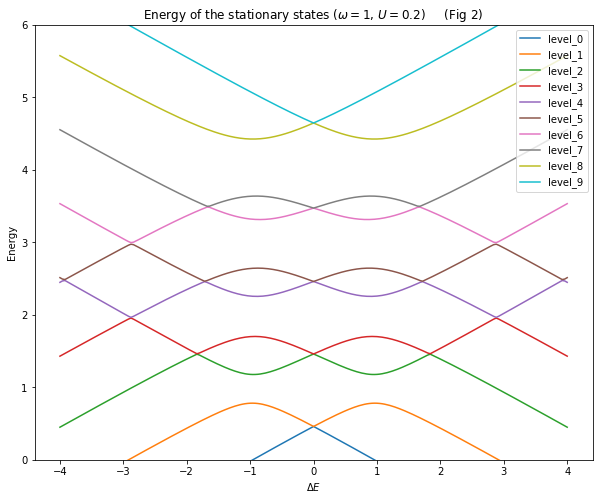

In [55]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[0,6],legend=True, 
        title="Energy of the stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

There are many things to say about what we see in Fig 2.

Two main features are:
1. the splitting of the levels increases with increasing level number i.e increasing number of bosons. 
2. not all crossings have been split apart into avoided crossings as we expected - this means some levels don't interact with each other at all. 

On 1. Applying our knowledge from Tutorial 1, we would say that the effective coupling between levels (which is proportional to the level splitting) increases with increasing boson number

On 2. Upon closer inspection we can see that the level splittings only occur when $\Delta E  \approx n \omega$ where n is an odd integer (we'll come to why we now use $\approx$ instead of = shortly). Although it is hard to see in Fig 2, if we zoom in on $\Delta E \approx 3\omega$ we can indeed see an anti-crossing:

In [56]:
max_bosons = 4
df = make_df_for_energy_scan("$\Delta E$", 2.8, 3, 201, 2*(max_bosons+1))

for i, row in df.iterrows():
    # Note below the "_" are used because right now we don't want to save the component parts of the Hamiltonian
    H,_ = make_hamiltonian(max_bosons=max_bosons, delta_E=row["$\Delta E$"], omega=1, U=0.2)
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals   # Fills the columns 1 onwards of row i with the eigenvalues

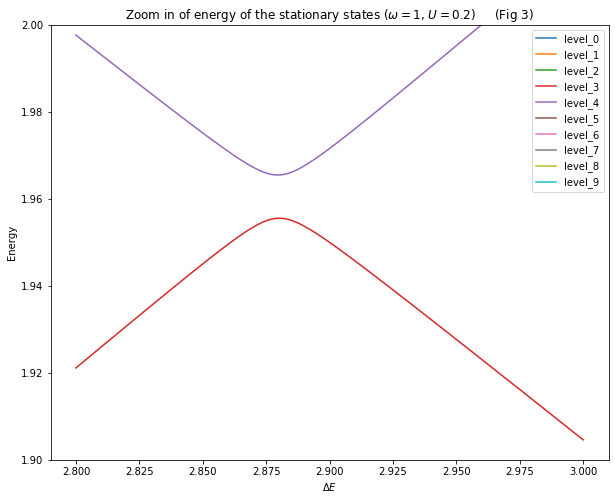

In [57]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[1.9,2],legend=True, 
        title="Zoom in of energy of the stationary states ($\omega=1$, $U=0.2$)     (Fig 3)");
plt.ylabel("Energy");



The level splitting seen in Fig 3 is much smaller than those seen in Fig 2 at the primary resonance ($\Delta E \approx \omega$). We can therefore say that the effective coupling between levels is much less for the non-primary resonances.

Fig 3 also shows us that the location of resonance is somewhat shifted, i.e. the anti-crossing does not occur when $\Delta E = 3 \omega$ but instead $\Delta E \approx 3\omega$. This shift is known as the [Bloch-Siegert shift](https://en.wikipedia.org/wiki/Bloch-Siegert_shift) (see also [Cohen-Tannoudji](https://iopscience.iop.org/article/10.1088/0022-3700/6/8/007) and [Hagelstein](https://iopscience.iop.org/article/10.1088/0953-4075/41/3/035601)).

>TODO: Classical meaning of Bloch-Siegert shift

This shift arises because we have to consider the effect of the interaction energy in the Hamiltonian ($E_{I}$) on the  resonance condition. Specifically, the resonance condition should instead be written as $\Delta E + E_{I} = 3\omega$ and hence the value of $\Delta E$ needed for resonance is somewhat reduced. 

> TODO:Make referenced to dressed atom picture https://www.youtube.com/watch?v=k0X7iSaPM38 and https://ocw.mit.edu/courses/physics/8-422-atomic-and-optical-physics-ii-spring-2013/

Fig 3 is also showing us something we haven't seen before. A resonance at $\Delta E \approx 3\omega$ suggests that it might be possible for the two state system transition to result in the emission of 3 smaller bosons rather than a single larger one (as we have seen previously when $\Delta E \approx \omega$ ). We'll investigate the possibility of this "down conversion" shortly.

In the meantime, let's try and understand why some levels don't couple to each other. For this we need to visualise the Hamiltonian. QuTiP offers a function called [`hinton`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=hinton#qutip.visualization.hinton) for just such a purpose.

We'll work with a Hamiltonian with a very large coupling of $U=1$ so that we'll be able to see things more clearly.

In [92]:
max_bosons = 4
H,h = make_hamiltonian(max_bosons=max_bosons, delta_E=1, omega=1, U=1)

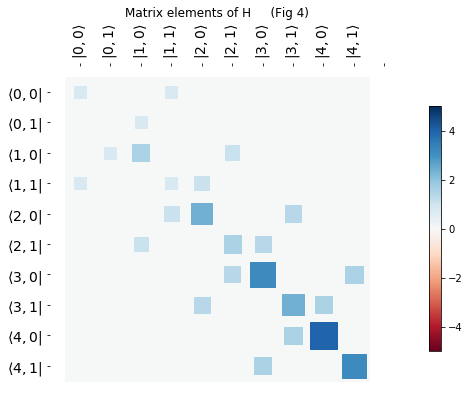

In [84]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 4)");

The colour and size of the squares in Fig 4 give you a measure of the how large different matrix elements are. The off diagonal elements arise solely from the interaction part of the Hamiltonian - this is what allows one state to (in a sense) "mutate" into another.

We'll study Fig 4 in more detail shortly, but for now I want to draw you attention to the labels for the rows and columns. For example, $|3, 0 \rangle$ represents 3 bosons and the two state system in the 0 state. The two state system numbers are handled somewhat confusingly in QuTiP, namely opposite to what you'd expect $0 \rightarrow +$ and $1\rightarrow -$. It will be helpful to have a way to map these QuTiP states to something more immediately recognisable, i.e. $|3, + \rangle$.

In [39]:
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

In [40]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

We can create some nice labels corresponding to the `nm_list`. This will make things like the hinton plot a lot easier to understand.

In [85]:
bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]

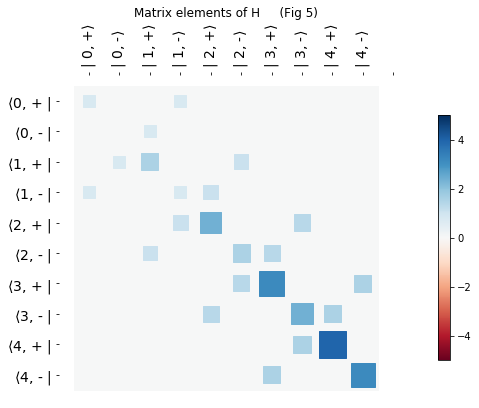

In [86]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

That's better!

If we now take a closer look at the structure of the Hinton diagram we can see some interesting features when we follow a path that connects one state to another:

                Matrix elements of H     (Fig 6)


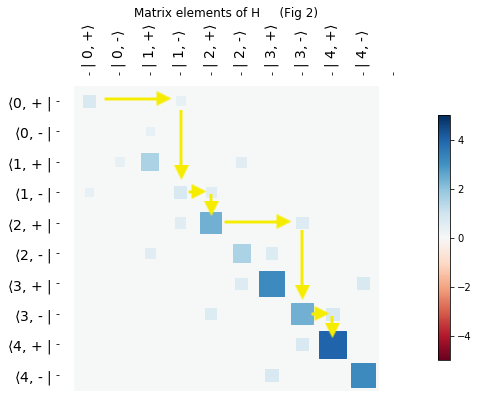

In [70]:
print("                Matrix elements of H     (Fig 6)")
Image(filename='parity.png') 

If we imagine starting a simulation with 0 bosons and the two state system in its + state, i.e. |0,+>, then Fig 6 suggests that:
1. there are connections (albeit indirect) from |0,+> to many different states with many more bosons, e.g. $|0,+> \rightarrow |1,-> \rightarrow |2,+> \rightarrow |3,-> \rightarrow |4,+> ...$.
2. there are some states that are not accessible at all if we start in the |0,+> state

On 1. These indirect connections provide a mechanism to achieve the down conversation that we saw hints of earlier.

On 2. The Hamiltonian appears to be composed of two separate "universes" that don't interact with each other. In our energy level diagram (Fig 2) both universes are present - perhaps if we separate them we'll only see anti-crossings in the respective plots.

What separates these universes is a form of [parity](https://en.wikipedia.org/wiki/Parity_%28physics%29). Parity is not particularly intuitive and a full discussion of it is somewhat involved and takes us deep into the topic of transition [selection rules](https://en.wikipedia.org/wiki/Selection_rule) - we'll come back to this another time.

For now, the the important thing to note is [how the parity operator $P$ acts on the system](https://iopscience.iop.org/article/10.1088/0305-4470/29/14/026):
- for the two state system $P |\pm> = \pm1|\pm> $, i.e. parity operator is the same as $\sigma_z$
- for [the field](https://ia801608.us.archive.org/11/items/TheParityOperatorForTheQuantumHarmonicOscillator/partity_article.pdf) with $n$ bosons $P |n> = -1^n |n>$, i.e. the parity is $-1^n = e^{i\pi n}$ 

Note, that we can use QuTiP's [`expm`](http://qutip.org/docs/latest/apidoc/classes.html#qutip.Qobj.expm) function to create the exponential operator from the number operator $n = a^{\dagger}a$. The combined parity is made by multiplying the two together. Let's see this in action:

In [72]:
sz = h["sz"]
a = h["a"]
num = a.dag()*a

In [73]:
P = sz*(1j*np.pi*num).expm()

Creating a hinton diagram for the parity operator is revealing:

In [77]:
f, ax = hinton(P, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 7)");

In Fig 7, we see that the the blue squares (parity=+1, often called even) matches up with the path of the yellow arrows in Fig 6. It is suggesting that if we start on a blue/red square then we remain on a blue/red square - much like a bishop in a game of chess.

To check this, we need to look at the [`commutator`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.operators.commutator) between the Hamiltonian and parity:

In [76]:
commutator(H,P)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

A zero commutator tells us that parity is conserved as the system evolves.

We can therefore split up the description of our system into two universes based on whether the states have even (+1) parity or odd (-1) parity.

In [87]:
P

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]

In [89]:
state_number_index([max_bosons+1,2],(3,0))

6

In [ ]:
nm_list

In [114]:
even

array([0, 3, 4, 7, 8])

In [108]:
even = np.where(P.diag()==1)[0]
odd = np.where(P.diag()==-1)[0]

In [109]:
H2 = H.extract_states(even)

In [110]:
H2

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[1.         1.         0.         0.         0.        ]
 [1.         1.         1.41421356 0.         0.        ]
 [0.         1.41421356 3.         1.73205081 0.        ]
 [0.         0.         1.73205081 3.         2.        ]
 [0.         0.         0.         2.         5.        ]]

In [ ]:
def make_hamiltonian(max_bosons, delta_E, omega, U, parity):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    P = sz*(1j*np.pi*num).expm()                   # parity operator
    
    two_state     =  delta_E/2*sz                   # two state system energy
    bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
    interaction  = U*(a.dag() + a) * sx            # interaction energy
    
    H = two_state + bosons + interaction
    
    components = {"a":a, "sx":sx, "sz":sz, "two_state":two_state, "bosons": bosons, "interaction":interaction}
    
    return H, components

In [115]:
max_bosons = 4
df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, (max_bosons+1))

for i, row in df.iterrows():
    # Note below the "_" are used because right now we don't want to save the component parts of the Hamiltonian
    H,_ = make_hamiltonian(max_bosons=max_bosons, delta_E=row["$\Delta E$"], omega=1, U=0.2)
    evals, ekets = H2.eigenstates()
    df.iloc[i,1:] = evals   # Fills the columns 1 onwards of row i with the eigenvalues

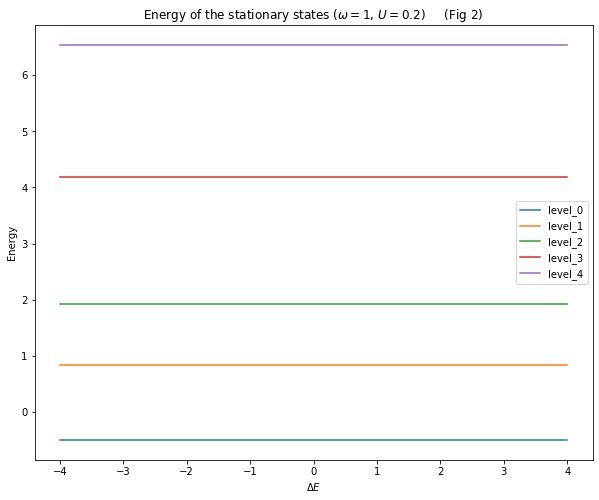

In [117]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[0,6],legend=True, 
        title="Energy of the stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

In [ ]:
#inspired by SJB code https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L56
if parity != "all":
    S=1/2
    possible_ns = range(0, max_bosons+1)
    possible_ms = - (np.arange(2*S+1) - S)
    Smn_list = product([S], possible_ns, possible_ms)

    if parity == "even":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 0]
    elif parity == "odd":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 1]

    subset_idx = []
    for s in mn_from_index:
        subset_idx.append(state_number_index([max_bosons+1,2],s))
    
    # Labels for hinton plots in case we want to plot it later (use xlabels=ket_labels, ylabels = bra_labels)
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+"|" for (n,m) in mn_from_index]
    ket_labels = ["|"+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in mn_from_index]

        # http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states
    two_state    = two_state.extract_states(subset_idx) 
    bosons      = bosons.extract_states(subset_idx) 
    interaction  = interaction.extract_states(subset_idx) 
    number          = (a.dag()*a).extract_states(subset_idx)
    spin         = spin.extract_states(subset_idx)

Let's see if these features arise in the simulation and if so what do they mean?

In [108]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))

In the previous tutorials we have been using QuTiP's [`sesolve`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.sesolve) to simulate the system. `sesolve` solves the Schrödinger equation. This was convenient as for us when we were getting started - we only needed a single line of code to run the simulation. It was especially useful when we introduced a time dependent perturbation to our two state Hamiltonian in Tutorial 2. However, `sesolve` will cause us problems as we increase the number of bosons that we want to simulate - the simulation will take too long to run.

Technically, we don't actually need a special solver like `sesolve` when dealing with time-independent problems (like ours). The business of solving the Schrödinger equation can be reduced to a problem of finding the eigenvalues and eigenvectors of the Hamiltonian.

Let's see how it works and then go through an example:

1. Transform initial state $\psi_0$ into a new basis defined by the eigenvectors (aka eigenkets) of the Hamiltonian i.e. the states of constant energy (represented here by $|i>$)
  - $\psi_0 = \underset{i}{\Sigma}   <i|\psi_0> |i>$
  -  $<i|\psi_0> = $ `psi0.transform(ekets)[i]`
2. Evolve each part of the state according to its eigenfrequency (aka eigenvalues) $\omega_i$
  - $\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i>$
  - $\omega_i =$ `evals[i]`
3. Transform the evolved state back into the basis we started with (represented here by $|k>$)
  - $\psi (t)= \underset{i,k}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ <k|i>|k>$
  - $<k|i> = $ `ekets[i][k]`

Let's see this in action.

**Step 1**:

In [109]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

In [110]:
psi0_in_H_basis

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.47943477]
 [ 0.        ]
 [-0.60720149]
 [-0.62306962]
 [ 0.        ]
 [ 0.        ]
 [ 0.11405024]
 [ 0.        ]
 [-0.01501479]]

This way of representing $\psi_0$ shows us that $|0,+>$ is mainly a mixture of the 3rd and 4th energy states. QuTiP has a convenient way of visualising the probabilities associated with such a state using [`plot_fock_distribution`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=plot_fock_distribution#qutip.visualization.plot_fock_distribution)

In [111]:
plot_fock_distribution(psi0_in_H_basis, title=f" |0,+> in constant energy basis     (Fig 4)")
plt.xlim(-1,10);

Continuing to follow the procedure, we have:

$\psi_0 = \underset{i}{\Sigma}  <i|\psi_0> |i> \\
\ \ \ \ = 0 |0> + 0.479 |1> + 0 |2> - 0.607 |3> ...$

**Step 2:**

The frequencies are given by the eigenvalues of the Hamiltonian:

In [112]:
evals

array([-0.6414331 , -0.49679612,  0.36267918,  0.83741561,  1.93063616,
        2.18752387,  3.67534047,  4.18717316,  6.41588958,  6.54157119])

and so (dropping the zero terms from step 1) the evolved state becomes:

$\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i> \\
\ \ \ \ =  0.479 e^{-i (-0.497)t}|1> +-0.607 e^{-i 0.837t} |3> ...$

**Step 3:**

Taking only the $|1>$ part form step 2 above for the sake of brevity, we only need to look at `ekets[1]`

In [113]:
ekets[1]

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 0.47943477]
 [ 0.        ]
 [ 0.        ]
 [-0.71761611]
 [ 0.4205095 ]
 [ 0.        ]
 [ 0.        ]
 [-0.26302551]
 [ 0.09570139]
 [ 0.        ]]

Then:

$0.479 e^{-i (-0.497)t}|1> \rightarrow 0.479 e^{-i (-0.497)t}0.479|0'> + 0.479 e^{-i (-0.497)t}(-0.754)|3'> + 0.479 e^{-i (-0.497)t}0.421|4'> ...$

where the prime in $|n'>$ indicates the original basis and not the energy basis. We can relabel these states to be the more familiar $|n,\pm>$ using the list we made earlier:

In [114]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

From this we see that:

$|0'> = |0,+>$,  

$|3'> = |1,->$ 

$|4'> = |2,+>$

and so we have:

$0.479 e^{-i (-0.497)t}|1> \rightarrow 0.479 e^{-i (-0.497)t}0.479|0,+>  + 0.479 e^{-i (-0.497)t}(-0.754)|1,-> + 0.479 e^{-i (-0.497)t}0.421|2,+> ...$

All of the above can be automated by making a function that we can reuse again and again:

In [127]:
def simulate(H, psi0, times):
    psi = np.zeros([(max_bosons+1)*2,times.size], dtype="complex128")
    P = np.zeros([(max_bosons+1)*2,times.size], dtype="complex128")
    
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)

    for k in range(0,(max_bosons+1)*2):
        amp = 0
        for i in range(0,(max_bosons+1)*2):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        psi[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, psi

In [116]:
times = np.linspace(0.0, 14.0, 100)
P, psi = simulate(H, psi0, times)

In [117]:
plt.figure(figsize=(10,8))
for i in range(0,(max_bosons+1)*2):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.title("(Fig 5)")
plt.show();

Fig 5 is the equivalent of Fig 2 from the previous tutorial - the only significant difference is the coupling is now much larger. 

Whereas previously we saw only the Rabi oscillation between $|0,+>$ and $|1,->$, now we see much more. There is significant probability of finding the system with more than 1 boson - as was suggested in the Hinton diagram.

But, how is such a thing possible? Doesn't it violate conservation of energy? After all, 2 or more bosons have more energy than the + state we started in. 

As you might suspect, the answer is no, energy is conserved, the "missing" energy comes from the interaction term in the Hamiltonian. We can see this explicitly by looking at the expectation values various parts of the Hamiltonian. QuTiP does allow us to do this using the [`expect`](http://qutip.org/docs/latest/guide/guide-states.html#expectation-values) function.


It works in the following way for the expectation of the Hamiltonian H:

`expect(H, state)`

We have the values of the `state` at every time step from the `A` output of our `simulate` function. We must however turn those values into a QuTiP quantum object ([`Qobj`](http://qutip.org/docs/latest/guide/guide-basics.html#the-quantum-object-class)) that has dimensions compatible with the interaction operator. For example, the dimensions of $\psi_0$ are:

In [62]:
psi0.dims

[[5, 2], [1, 1]]

We can use the `dims` of $\psi_0$ to create a compatible `Qobj` in the following way (e.g. for time step 10)

In [63]:
d = [[5, 2], [1, 1]]
state = Qobj(psi[:,10],dims=d)

The expectation value of the interaction energy at time step 10 is then:

In [64]:
expect(H, state)

1.0000000000000018

We could automate this process, but it turns out that creating the `Qobj` for every time step can be very slow. We will instead directly calculate the expectation value using matrix multiplication, i.e.

$<H> = \psi^{\dagger}H\psi = \psi^{\dagger} @ (H @\psi) $

Where @ is the matrix multiplication operator and $\dagger$ in this context means taking the complex conjugate. For the 10th time step we have:

In [65]:
np.conj(psi[:,10])@ (H @ psi[:,10])

(1.0000000000000018+0j)

Let's automate this process for all time steps using a function.

In [118]:
def expectation(operator, states):
    operator_expect = []
    for i in range(0,shape(states)[1]):
        e = np.conj(states[:,i])@ (operator @ states[:,i])
        operator_expect.append(e)
    return operator_expect

We can now see how the different parts of the Hamiltonian change overtime

In [119]:
hamiltonian_expect = expectation(H,psi)
two_state_expect = expectation(two_state,psi)
bosons_expect = expectation(bosons,psi)
interaction_expect = expectation(U*interaction,psi)

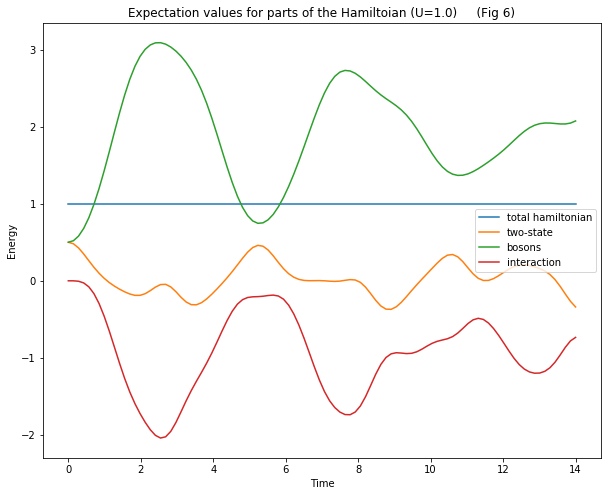

In [120]:
plt.figure(figsize=(10,8))
plt.plot(times, hamiltonian_expect, label="total hamiltonian")
plt.plot(times, two_state_expect, label="two-state")
plt.plot(times, bosons_expect, label="bosons")
plt.plot(times, interaction_expect, label="interaction")

plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for parts of the Hamiltoian (U={U})     (Fig 6)")
plt.show();

Fig 6 confirms that the total energy (the blue line) is constant - energy conservation is not violated. We can also see that that the interaction energy is dominating over the two-state energy. This is what is allowing the boson energy to get higher than we might expect by only considering the two state energy and the bosons. This is not the case when the coupling is weak (as in the previous tutorial). Let's compare, by making the coupling 100 times weaker.

In [124]:
U = delta_E/100
H = two_state + bosons + U*interaction
times = np.linspace(0.0, 1400.0, 10000)
P, psi = simulate(H, psi0, times)

In [125]:
hamiltonian_expect = expectation(H,psi)
two_state_expect = expectation(two_state,psi)
bosons_expect = expectation(bosons,psi)
interaction_expect = expectation(U*interaction,psi)

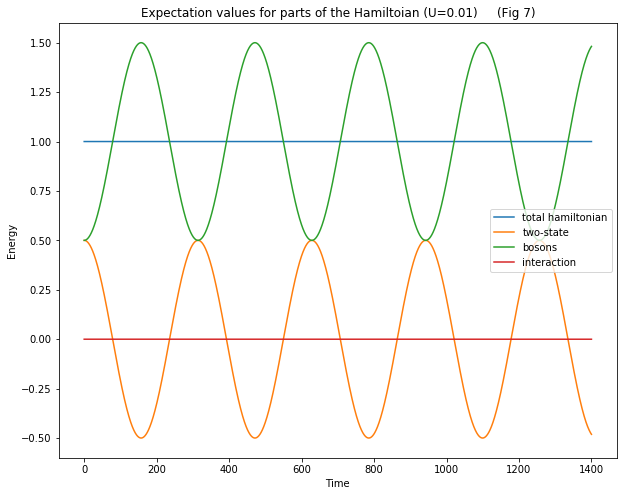

In [126]:
plt.figure(figsize=(10,8))
plt.plot(times, hamiltonian_expect, label="total hamiltonian")
plt.plot(times, two_state_expect, label="two-state")
plt.plot(times, bosons_expect, label="bosons")
plt.plot(times, interaction_expect, label="interaction")

plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for parts of the Hamiltoian (U={U})     (Fig 7)")
plt.show();

Fig 7 shows that the behaviour in the weak coupling case is much more as we would expect, i.e. the bosons "trade" energy with the two-state system.

Strong coupling is not as intuitive as weak coupling. Specifically, it is not obvious how to interpret the interaction energy. We'll instead look at some of the consequences.

In [1084]:
delta_E = 4.525252525252525
max_bosons = 100
omega = 1
U = 1

# delta_E = 2.9996999918083977
# max_bosons = 100
# omega = 1
# U = 0.01

In [1085]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator

two_state     =  delta_E/2*sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction  = (a.dag() + a) * sx             # interaction energy

H = two_state + bosons + U*interaction

In [1086]:
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

In [1087]:
bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]

In [1088]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))

In [1093]:
times = np.linspace(0.0, 5000000.0, 1000)
times = np.linspace(0.0, 140.0, 1000)


P, psi = simulate(H, psi0, times)

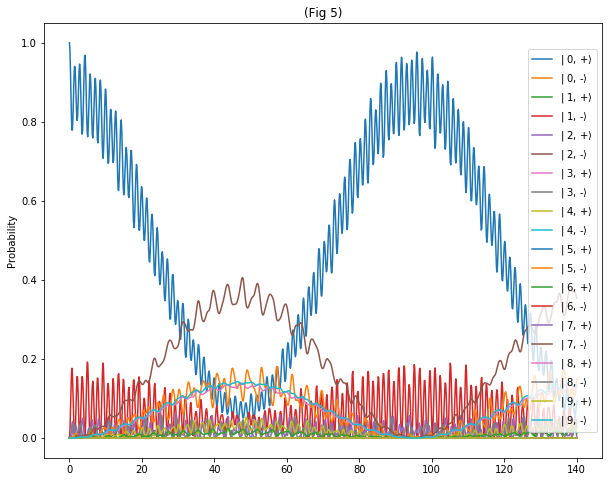

In [1094]:
plt.figure(figsize=(10,8))
# for i in range(0,(max_bosons+1)*2):
for i in range(0,20):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.title("(Fig 5)")
plt.show();

In [1095]:
hamiltonian_expect = expectation(H,psi)
two_state_expect = expectation(two_state,psi)
bosons_expect = expectation(bosons,psi)
interaction_expect = expectation(U*interaction,psi)

In [1096]:
# plt.figure(figsize=(10,8))
# plt.plot(times, boson_number_expect, label="bosons")

# plt.ylabel("Energy")
# plt.xlabel("Time")
# plt.legend(loc="right")
# plt.title(f"Expectation values for parts of the Hamiltoian (U={U})     (Fig 7)")
# plt.show();

plt.figure(figsize=(10,8))
plt.plot(times, hamiltonian_expect, label="total hamiltonian")
plt.plot(times, two_state_expect, label="two-state")
plt.plot(times, bosons_expect, label="bosons")
plt.plot(times, interaction_expect, label="interaction")

plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for parts of the Hamiltoian (U={U})     (Fig 7)")
plt.show();

In [33]:
P = sz*(1j*np.pi*a.dag()*a).expm()

In [38]:
(1j*np.pi*a.dag()*a).expm()

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]

In [37]:
P

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]

In [35]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [31]:
commutator(H,P)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [95]:
possible_ms

array([ 0.5, -0.5])

In [58]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))

In [59]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

In [60]:
times = np.linspace(0.0, 14.0, 100)

In [61]:
P = []

for k in range(0,(max_bosons+1)*2):
    amp = 0
    for i in range(0,max_bosons+1):
        amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
    P.append(amp*np.conj(amp))

In [119]:
plt.figure(figsize=(10,8))
for i in range(0,(max_bosons+1)*2):
    plt.plot(times, P[i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();

In [669]:
omega

1.0

## Calculate energy eigenvalues for different couplings

In [1312]:
delta_E = 1.0            # two level energy difference
N = 1                    # number of phonon quanta needed to exite the atom
omega = delta_E / N          # phonon energy
max_bosons =  100             # Max mode number to simulation
num_U = 100                  # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
U_min = 0.01    # min atom phonon coupling
U_max = 1.2*delta_E     # maximum atom phonon coupling

In [1313]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())             # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())              # tensorised sigma_z operator

two_state     =  sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction   = (a.dag() + a) * sx*0.2     # interaction energy (needs to be multiplied by coupling constant)

number           = a.dag()*a  # phonon number operator
spin          = sz/2       # z component of spin

In [1314]:
H = two_state + bosons + interaction

In [1315]:
# f, ax = hinton(H)
# ax.tick_params(axis='x',labelrotation=90)
# ax.set_title("Matrix elements of H     (Fig 1)");

In [1316]:
parity = "odd"

In [1317]:
#inspired by SJB code https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L56
if parity != "all":
    S=1/2
    possible_ns = range(0, max_bosons+1)
    possible_ms = - (np.arange(2*S+1) - S)
    Smn_list = product([S], possible_ns, possible_ms)

    if parity == "even":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 0]
    elif parity == "odd":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 1]

    subset_idx = []
    for s in mn_from_index:
        subset_idx.append(state_number_index([max_bosons+1,2],s))
    
    # Labels for hinton plots in case we want to plot it later (use xlabels=ket_labels, ylabels = bra_labels)
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+"|" for (n,m) in mn_from_index]
    ket_labels = ["|"+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in mn_from_index]

        # http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states
    two_state    = two_state.extract_states(subset_idx) 
    bosons      = bosons.extract_states(subset_idx) 
    interaction  = interaction.extract_states(subset_idx) 
    number          = (a.dag()*a).extract_states(subset_idx)
    spin         = spin.extract_states(subset_idx)

It will be helpful for us to be able to search for the index of a particular state by the (n,m) numbers

In [1318]:
def index_from_nm(n,m): 
    try:
        return [item for item in mn_from_index].index((n,m))
    except:
        print("ERROR: State doesn't exist or has the wrong parity ")

In [1319]:
# H = two_state + bosons + interaction
# f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
# ax.tick_params(axis='x',labelrotation=90)
# ax.set_title("Matrix elements of H     (Fig 1) EVEN");

In [1320]:
# d = {"coupling":np.linspace(U_min,U_max,num_U)}
d = {"E":np.linspace(-4,4*delta_E,100)}
for i in range((max_bosons+1)):
#     d[f"level_{i}"] = np.zeros(num_U)
    d[f"level_{i}"] = np.zeros(100)
    
df = pd.DataFrame(data=d)


# We'll create some dataframes to store expectation values for: 
df_num = pd.DataFrame(data=d) # phonon number
df_sz = pd.DataFrame(data=d)  # z component of spin
df_int = pd.DataFrame(data=d) # interaction energy

In [1321]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
#     H = two_state + bosons + row.coupling*interaction
    H = two_state*row.E/2 + bosons + interaction
    evals, ekets = H.eigenstates()
#     df.iloc[index,1:] = np.real(evals/omega)
    df.iloc[index,1:] = np.real(evals)
    
#     # We'll also calculate some expectation values so we don't have to do it later
#     df_num.iloc[index,1:] = expect(number,ekets)           # phonon number
#     df_sz.iloc[index,1:] = expect(spin,ekets)           # z component of spin
#     df_int.iloc[index,1:] = expect(row.coupling*interaction,ekets)   # interaction energy

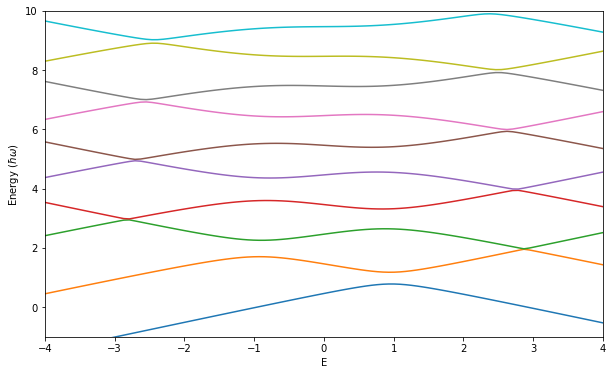

In [1323]:
df.plot(x="E",ylim=[-1,10],xlim=[-4,4],figsize=(10,6),legend=False);
plt.ylabel("Energy ($\hbar\omega$)");

In [1026]:
ind = (df["level_2"]-df["level_1"]).argmin()

In [1027]:
df["E"].iloc[ind]

2.9696969696969697

In [1127]:
# H = two_state*2.9996999918083977/2 + bosons + interaction
H = two_state*3/2 + bosons + interaction

In [1128]:
evals, ekets = H.eigenstates()

In [1129]:
plot_fock_distribution(ekets[1], title=f" |0,+> in constant energy basis     (Fig 4)")
plt.xlim(-1,10);

In [1130]:
plot_fock_distribution(ekets[2], title=f" |0,+> in constant energy basis     (Fig 4)")
plt.xlim(-1,10)

(-1, 10)

In [1032]:
# Define a function which returns the energy difference between two levels for a given coupling
def ev(E,i):
    H = two_state*E/2 + bosons + interaction
    evals, ekets = H.eigenstates()
    return evals[i] - evals[i-1] 

In [1033]:
dE = 7*delta_E/100

In [1034]:
res = minimize_scalar(ev,args=2,bracket=[df["E"].iloc[ind]-dE, df["E"].iloc[ind]+dE])

In [1035]:
res.x

2.9996999918083977

In [1036]:
res.fun

1.2247909986218275e-06

## More detail on energy levels 7 and 8

In [224]:
level_number_1 = 2
level_number_2 = 3

In [225]:
level_label_1 = f"level_{level_number_1}"
level_label_2 = f"level_{level_number_2}"

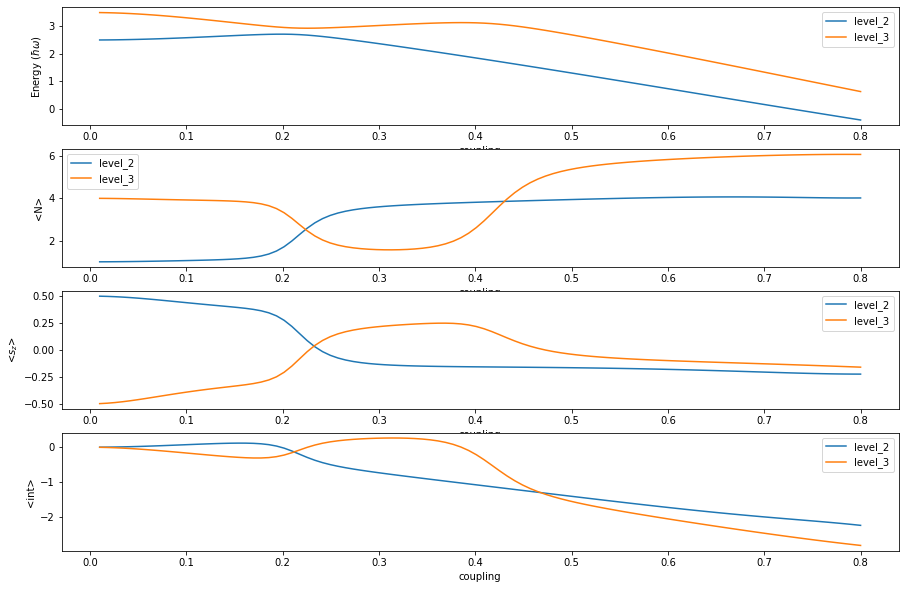

In [226]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10))
df[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[0]);
df_num[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[1]);
df_sz[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[2]);
df_int[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[3]);
axes[0].set_ylabel("Energy ($\hbar\omega$)")
axes[1].set_ylabel("<N>")
axes[2].set_ylabel("<$s_z$>");
axes[3].set_ylabel("<int>");

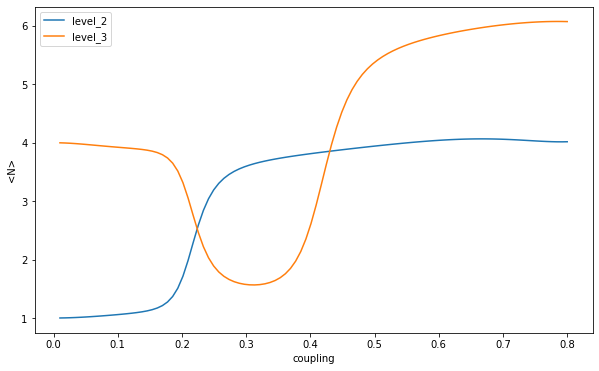

In [227]:
df_num[["coupling",level_label_1,level_label_2]].plot(x="coupling",figsize=(10,6));
plt.ylabel("<N>");

## Find the anti-crossing points

### Start with rough calculation of the anti-crossing coupling

In [228]:
df_diff = df.drop('coupling', axis=1).diff(axis=1).dropna(axis=1)
df_diff["coupling"] = df["coupling"]

In [229]:
level_label = level_label_2

df_diff_subset = df_diff[["coupling",level_label]]
df_diff_subset["min"] =  df_diff_subset[[level_label]].min(axis=1)
df_diff_subset["level_min"] = df_diff_subset[[level_label]].idxmin(axis=1).str.split("_",expand = True)[1]

argmin = argrelextrema(df_diff_subset["min"].values, np.less)[0]
anti_crossing = df_diff_subset.iloc[argmin][["coupling","min","level_min"]]
anti_crossing.reset_index(inplace=True,drop=True)

In [230]:
anti_crossing

coupling       min level_min
0  0.209495  0.233773         3

### Now more precise calculation of anti-crossing couplings

In [231]:
# Define a function which returns the energy difference between two levels for a given coupling
def ev(U,i):
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    return evals[i] - evals[i-1] 

In [232]:
dU = (U_max - U_min)/num_U

In [233]:
for index, row in anti_crossing.iterrows():
    res = minimize_scalar(ev,args=int(row["level_min"]),bracket=[row["coupling"]-dU, row["coupling"]+dU])
    anti_crossing.loc[index, "coupling"] = res.x
    anti_crossing.loc[index, "min"] = res.fun

In [234]:
anti_crossing

coupling      min level_min
0  0.211934  0.11659         3

## Simulation of the first anti-crossing

### First let's look at some expectation values at the anti-crossing

In [235]:
H = two_state + bosons + anti_crossing.loc[0]["coupling"]*interaction
# H = two_state + bosons + 0.15*interaction
# H = two_state + bosons + 0.531938*interaction # for N=1
# H = two_state + bosons + 0.08103160077219432*interaction # for N=11
evals, ekets = H.eigenstates()

In [236]:
print("state", "energy", "number", "spin")
for i in range(level_number_1-3,level_number_2+3):
    print(i, evals[i]/omega, expect(number,ekets[i]), expect(spin,ekets[i]))

state energy number spin
-1 106.26853785299124 98.56128153769299 0.06483392176941205
0 -0.5624193580614852 0.025321800904233745 -0.4787725126047104
1 1.0896370918203657 1.916117640272339 -0.32807283111615027
2 2.703986773518986 2.0749194009847955 0.19917314837391586
3 2.937166636128328 2.9664966239141397 -0.13002546389608485
4 4.590278821998608 5.436922488762485 -0.12180307700868674
5 5.094454911504115 3.6360500775342692 0.16749705090302527


We see above that levels 7 and 8 are almost identical which confirms what we see in the figures above

### What are the anti-crossing eigenstates made of?

In [237]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_fock_distribution(ekets[level_number_1], title=f"{level_number_1} Eigenstate", ax=axes[0])
plot_fock_distribution(ekets[level_number_2],title=f"{level_number_2} Eigenstate", ax=axes[1])
axes[0].set_xlim(-1,25)
axes[1].set_xlim(-1,25)
fig.tight_layout()

The Energy eigenstates that come together at the anti-crossing are mostly made up of states numbered:

In [238]:
P_eigenstate = ekets[level_number_1].full()*np.conj(ekets[level_number_1].full())
P_eigenstate = np.hstack(P_eigenstate)
eigenstate_composition = P_eigenstate.argsort()[-2:][::-1]
print(eigenstate_composition[0], ",", eigenstate_composition[1])

1 , 4


What do these numbered states corresponds to? We can use the `mn_from_index` to find the n and m numbers.

In [239]:
print ( mn_from_index[eigenstate_composition[0]], ",", mn_from_index[eigenstate_composition[1]])

(1, 0) , (4, 1)


### What does the most dominate part look like in basis of the eigenstates?

We should create the state by using `tensor` function and the extracting the states that have the wrong parity. We can however create the state directly from the `basis` function using the index we found above.

In [240]:
i0 = eigenstate_composition[0]

In [241]:
psi0 = basis(max_bosons+1, i0)

In [242]:
psi0_in_H_basis = psi0.transform(ekets)

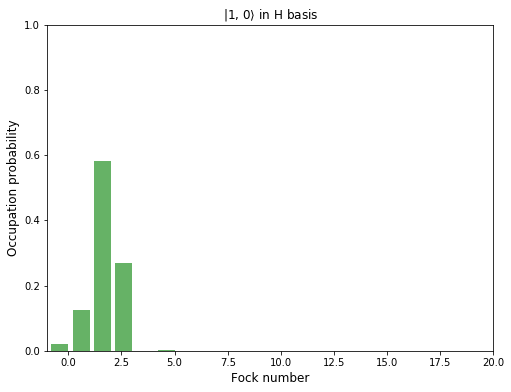

In [243]:
plot_fock_distribution(psi0_in_H_basis, title=f"{ket_labels[i0]} in H basis")
plt.xlim(-1,20);

so |1,0> (ie 1 bosons and lower state for two state system) is mixture of eigenstates 7 and 8.

Therefore if we start the system off in |1,0> we can expect it to rabi oscillate between 7 and 8 which should give us some oscilation between |1,0> and |14,1>. 

Let's see

In [244]:
P = []

for i in range(0,max_bosons+1):
    psi = basis(max_bosons+1,i)
    P.append(psi*psi.dag())

In [245]:
times = np.linspace(0.0, 1000.0, 10000)      # simulation time

result = sesolve(H, psi0, times,P)

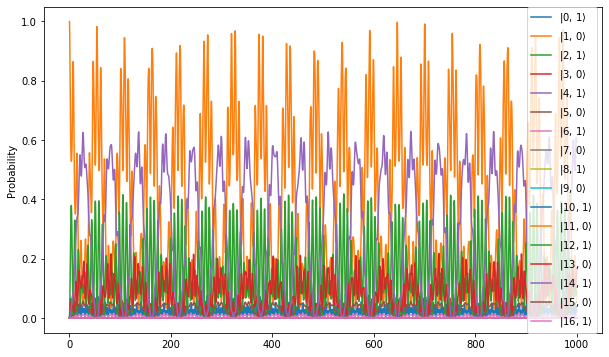

In [246]:
plt.figure(figsize=(10,6))
for i in range(0,17):
    plt.plot(times, result.expect[i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();



Not much osccilation at all!

Maybe we need to wait longer. Let's manually do a time varying state otherwise it will take a very long time.

> TODO: explain the method below

In [250]:
times = np.linspace(0.0, 1000000.0, 10000)

In [251]:
P = []

for k in range(0,max_bosons+1):
    amp = 0
    for i in range(0,max_bosons+1):
        amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
    P.append(amp*np.conj(amp))

In [252]:
plt.figure(figsize=(10,8))
for i in range(0,20):
    plt.plot(times, P[i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();

Seems like we'd have to wait a really long time to see the Rabi oscillation.

### How sensitive is the anti-crossing?

In [414]:

# Us = np.linspace(anti_crossing.loc[0]["coupling"]/10,2*anti_crossing.loc[0]["coupling"],40)

Us_min = anti_crossing.loc[0]["coupling"] - anti_crossing.loc[0]["coupling"]/5000
Us_max = anti_crossing.loc[0]["coupling"] + anti_crossing.loc[0]["coupling"]/5000
Us = np.linspace(Us_min,Us_max,21)
Ps = []
for U in Us:
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    times = np.linspace(0.0, 1000000.0, 10000)

    psi0 = basis(max_bosons+1, i0)
    psi0_in_H_basis = psi0.transform(ekets)

    P = []

    for k in range(0,max_bosons+1):
        amp = 0
        for i in range(0,max_bosons+1):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        P.append(amp*np.conj(amp))
    Ps.append(P)

NameError: name 'anti_crossing' is not defined

In [415]:
psi0_level = []
for U in Us:
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)
    P0 = psi0_in_H_basis.full()*np.conj(psi0_in_H_basis.full())
    P0 = np.hstack(P0)
    psi0_level.append(P0.argmax())

NameError: name 'Us' is not defined

In [482]:
@gif.frame
def plot(P,j):
    plt.figure(figsize=(10,8))
    for i in range(0,20):
        plt.plot(times, P[i], label=f"{ket_labels[i]}")
    plt.ylabel("Probability")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"U = {Us[j]}")

In [489]:
@gif.frame
def plot2(P,j):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    for i in range(0,20):
        axes[0].plot(times, P[i], label=f"{ket_labels[i]}")
    axes[0].set_ylabel("Probability")
    axes[0].set_xlabel("Time")
    axes[0].legend(loc="right")
    deltaU = (Us[j]-anti_crossing.loc[0]["coupling"])/anti_crossing.loc[0]["coupling"]*100
    axes[0].set_title(f"$\Delta U / U_{{anti\\times}}$ = {deltaU:.3f}%")
    df.plot(x="coupling",ylim=[-6,20],legend=False,ax=axes[1], title=f"Tracking energy level of {ket_labels[i0]} state");
    axes[1].set_ylabel("Energy ($\hbar\omega$)");
    axes[1].plot(Us[j],np.interp(Us[j],df["coupling"], df[f"level_{psi0_level[j]}"]),"ok")

In [490]:
frames = []
for j, P in enumerate(Ps):
    frame = plot2(P, j)
    frames.append(frame)
gif.save(frames, "anti-crossing-approach.gif", duration=500)

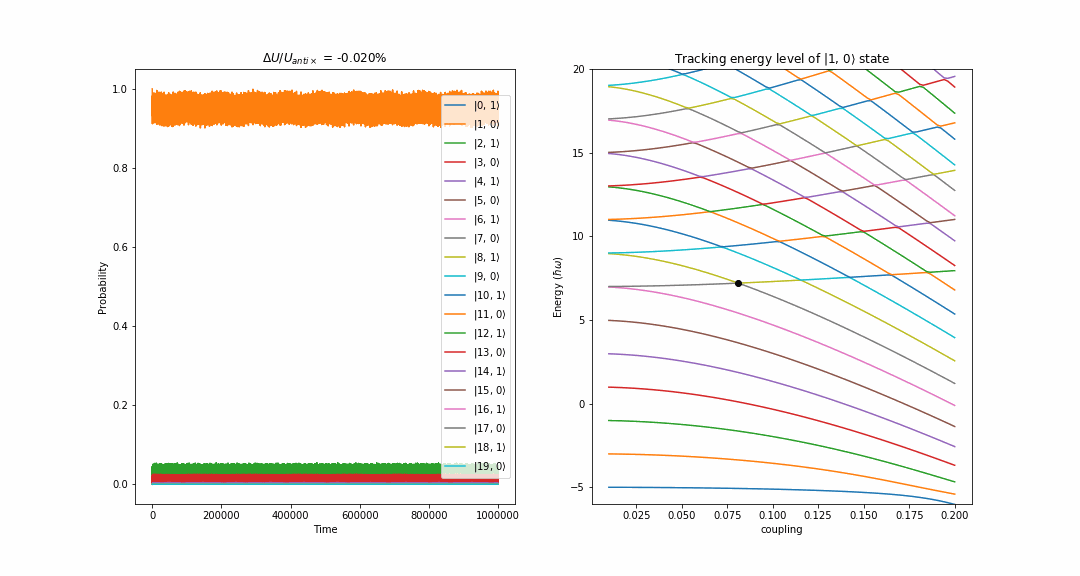

In [491]:
Image(filename="./anti-crossing-approach.gif")

In [ ]:
def index_from_nm(n,m): 
    try:
        return [item for item in nm_list].index((n,m))
    except:
        print("ERROR: State doesn't exist")